# Tutorial 2.1: One-Body Potential Energy Surface

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [6]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.x.y Normal Modes Configuration Generation

Now, we will generate the first batch of configurations for our training set. This batch will come from randomly sampling the vibrational normal modes of methylamine.

First, we need to calculate the vibrational modes of the optimized geometry:

In [2]:
minimized_structure_CH3NH2 = read_system(monomer_CH3NH2_definition_path, monomer_CH3NH2_minimum_structure_path)
vibrational_modes_CH3NH2 = read_vibrational_modes(vibrational_modes_CH3NH2_path)

In [3]:
configuration_generator = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
        classical=False,
)
configurations_vibrational_modes_CH3NH2 = list(configuration_generator.generate_configurations(num_configs=1000, seed=54321))
write_systems(pip_1b_modes_configs_path, configurations_vibrational_modes_CH3NH2)

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.0001860524825039312 | x < 0.45 : 0.0009302624125196561 | x < 0.75 : 0.0018605248250393122 | x < 0.95 : 0.0037210496500786243 | otherwise : 0.00930262412519656 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 1000 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 1000 configs.


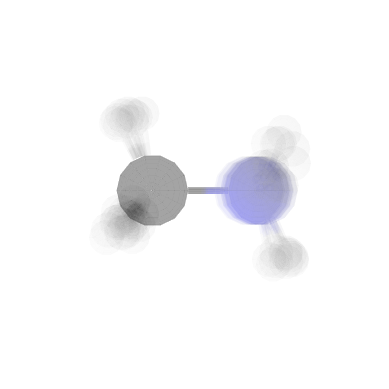

In [4]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.02,
    num_to_show=10
)

Note: the seed here determines which configurations get generated. The same seed will always produce the same configurations. In a later step, we "cheat" and have pre-performed the CCSD(T) calculations for these structures, so please don't change the seed, because then the energies we give you wont match the structures that get generated!

## II.1.? Parallel-Bias Metadynamics Configuration Generation

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

In [5]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        minimized_structure_CH3NH2
)

In [6]:
bond_params

{('A', 'B'): (30, 1.090363497904159),
 ('A', 'C'): (50, 1.4855635499551385),
 ('C', 'D'): (30, 1.0335460742804576)}

In [7]:
angle_params

{('A', 'C', 'D'): (10, 107.29140952068394),
 ('B', 'A', 'B'): (10, 108.21857211598058),
 ('B', 'A', 'C'): (10, 110.68095145727484),
 ('D', 'C', 'D'): (10, 104.35491531108244)}

In [8]:
nonbonded_params

{'A': (0.03, 2.4), 'B': (0.01, 1.2), 'C': (0.03, 2.4), 'D': (0.01, 1.2)}

In [9]:
perform_pbmetad_simulation(
        "/home/ebullvul/software/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [minimized_structure_CH3NH2],
        num_configs=5000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=pbmetad_configuration_pool_1b,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges={"A": 0.3, "B": 0.1, "C": -0.3, "D": 0.15},
        pbmetad_workdir=pbmetad_workdir_1b,
        restart_path=restart_dir.file("1b_pbmetad.restart")
)

PBMetaD already completed. Will not rerun!


In [15]:
split_pool(
        read_definition(monomer_CH3NH2_definition_path),
        pbmetad_configuration_pool_1b,
        pool_size=5000,
        num_configs_to_split=100,
        unsplit_path=pbmetad_configuration_pool_1b_pool_configs,
        split_path=pbmetad_configuration_pool_1b_test_configs,
        strategy="INTERVAL",
)

In [27]:
pbmetad_configs = perform_fps(
        read_definition(monomer_CH3NH2_definition_path),
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
        pbmetad_configuration_pool_1b_pool_configs,
        num_pool_configs=4900,
        num_phase1_input_configs=4000,
        approx_configs_to_select=1000,
        fps_workdir=fps_workdir_1b,
        restart_path=restart_dir.file("1b_fps.restart"),
        num_threads=16
)

Number of permutations: 12
Beginning featurization...
Featurization progress: |====================================================================================================| - 4000/4000
Featurized 4000 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 1000/1000
Completed round 1 fps, selected 1000 configs, max distance: 0.8838539705771418
Number of permutations: 12
Beginning featurization...
Featurization progress: |====================================================================================================| - 900/900
Featurized 900 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 101
Completed round 1 fps, selected 101 configs.


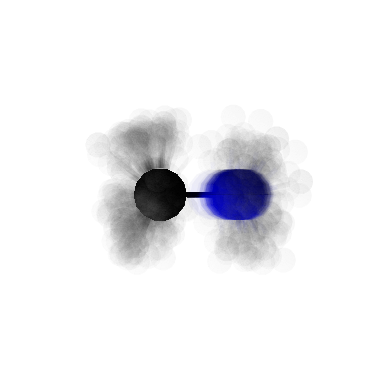

In [28]:
render_overlayed_systems(
    pbmetad_configs,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.02,
    num_to_show=100
)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [31]:
# calculator = OrcaCalculator("DLPNO-CCSD(T)-F12", "cc-pVTZ-F12", log_directory="test_logs", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {"AuxC": "cc-pVTZ/C", "CABS": "cc-pVTZ-F12-CABS"})
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [7]:
configurations_vibrational_modes_CH3NH2 = read_systems(monomer_CH3NH2_definition_path, pip_1b_modes_configs_path)
nm_configs_energies = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2 ,
        calculator,
        get_qchem_job_manager(jobs_dir),
        restart_dir.file("energies_1b_normal_modes_configs.restart"),
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(pip_1b_modes_configs_energies_path, (configurations_vibrational_modes_CH3NH2, nm_configs_energies))

NameError: name 'calculator' is not defined

## II.1.? Polynomial Generation

In [12]:
generate_polynomial(
        read_definition(monomer_CH3NH2_definition_path),
        max_degree=4,
        polynomial_info_path="test1.in",
        polynomial_dir=Directory("testpip"),
        filters=[]
)

(A1B3C1D2)
Generating polynomial input file for symmetry (A1B3C1D2) into file test1.in.
Successfully generated polynomial input file! 21 total variables.
Generating terms up to degree 4...
Generating polynomial: |====================================================================================================| - 84/84
8 possible degree 1 terms, now filtering them...
There were 8 accepted degree 1 terms.
53 possible degree 2 terms, now filtering them...
There were 53 accepted degree 2 terms.
292 possible degree 3 terms, now filtering them...
There were 292 accepted degree 3 terms.
1420 possible degree 4 terms, now filtering them...
There were 1420 accepted degree 4 terms.
There were 1773 accepted terms over all
Writing Gradients C++: |====================================================================================================| - 21/21
Writing Polynomial C++: |====================================================================================================| - 1773/1773


## II.1.? Polynomial Parametrization

In [40]:
read_parameters(Vphys_dir.file("charges_CH3NH2"))

{'A': 0.26466509254565174,
 'B': -0.024142906727783187,
 'C': -0.6608195412757641,
 'D': 0.234291584456731}

In [42]:
generate_pip_parametizer(
        read_definition(monomer_CH3NH2_definition_path),
        max_degree=4,
        polynomial_info_path="test1.in",
        polynomial_dir=Directory("testpip"),
        parametizer_dir=Directory("testfit"),
        workdir=Directory("testworkdir"),
        symmetry_to_charge=read_parameters(Vphys_dir.file("charges_CH3NH2")),
        symmetry_to_polarizability={**read_parameters(Vphys_dir.file("polarizabilities_CH3NH2")), **read_parameters(Vphys_dir.file("polarizabilities_H2O"))},
        symmetry_to_polarizability_factor={**read_parameters(Vphys_dir.file("polarizability_factors_CH3NH2")), **read_parameters(Vphys_dir.file("polarizability_factors_CH3NH2"))},
        symmetries_to_C6={},
        symmetries_to_d6={},
        monomer_names=["ch3nh2", "h2o"],
        is_mbpol=[False, True]
)

File testworkdir/config.ini already exists, moving existing testworkdir/config.ini to testworkdir/config.ini.backup-12 to make way for new file.
Completed generating config file testworkdir/config.ini.
File testworkdir/config.ini already exists, moving existing testworkdir/config.ini to testworkdir/config.ini.backup-13 to make way for new file.
Executing python generator script
Generating fitcode for molecule with symmetry A1B3C1D2...
Using mbpol for 1 fragments.
0 fragments have lone pairs.
Using exp variables for intramolecular interactions.
Using exp variables for intermolecular interactions.
Using coul variables for lone pair interactions.
1773 terms in the polynomial.
Atoms in the molecule: A1 B1 B2 B3 C1 D1 D2.
21 variables in the polynomial.
8 non-linear parameters in the polynomial.


## II.1.? Implementation in MBX

## II.1.? Test MBX Implementation

## II.1.? Run a Gas-Phase Monomer Simulation